# Project Description

## Histopathologic Cancer Detection

This project aims to develop a deep learning model to detect cancerous cells in histopathologic scans of lymph node sections. The primary goal is to classify images as either containing metastatic tissue or not, which is a critical task in cancer diagnosis and treatment planning.

### Problem Statement

Cancer detection in histopathologic images is a challenging task due to the complexity and variability of the tissue structures. Accurate and automated detection can significantly aid pathologists in diagnosing cancer, reducing the workload and improving the accuracy of diagnoses.

### Data Description

The dataset used in this project is the Histopathologic Cancer Detection dataset from Kaggle. It consists of high-resolution images of lymph node sections, each labeled as either containing metastatic tissue or not.

- **Training Data**: The training dataset contains images along with their corresponding labels indicating the presence of metastatic tissue.
- **Validation Data**: A subset of the training data is used for validation to tune the model and prevent overfitting.
- **Test Data**: The test dataset contains images without labels, used to evaluate the model's performance.

#### Data Size and Structure

- **Training Data**: 
    - Number of images: Approximately 220,025
    - Image dimensions: 96x96 pixels
    - Labels: Binary (0 for non-cancerous, 1 for cancerous)

- **Validation Data**:
    - Number of images: 20% of the training data
    - Image dimensions: 96x96 pixels
    - Labels: Binary (0 for non-cancerous, 1 for cancerous)

- **Test Data**:
    - Number of images: Approximately 57,458
    - Image dimensions: 96x96 pixels
    - Labels: Not provided (used for model evaluation)

The images are provided in `.tif` format and are pre-processed to a uniform size of 96x96 pixels. The dataset is balanced to ensure an equal representation of both classes.

This project demonstrates the application of deep learning techniques to medical image analysis, showcasing the potential of AI in healthcare.

Import the necessary libraries and modules for the project.

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim 
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from PIL import Image

## Loading of training and validation datasets

In [2]:
print(os.listdir("./kaggle/input/histopathologic-cancer-detection"))

['train', 'train_labels.csv', 'test']


loads the training labels from a CSV file, splits the data into training and validation sets, and prints the sizes of these sets. 

In [3]:
train_labels = pd.read_csv('./kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_labels.head())

#  Divide the train DataFrame into training and validation sets.
train_data, val_data = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])


print(f"Training size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Training size: 176020
Validation size: 44005


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis (EDA) on the training dataset to understand the distribution of classes, visualize sample images, and analyze the data's characteristics.

label
0    104726
1     71294
Name: count, dtype: int64


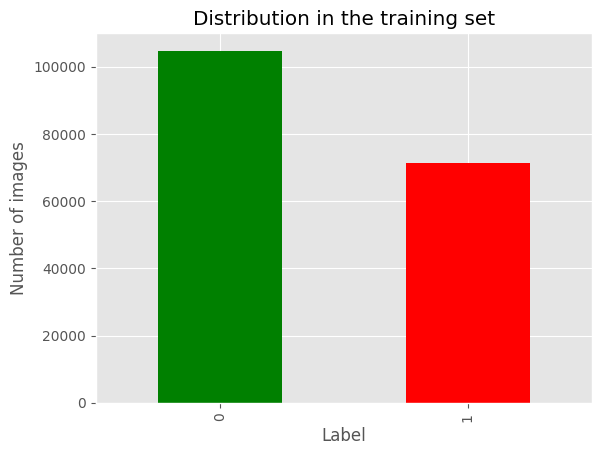

label
0    26182
1    17823
Name: count, dtype: int64


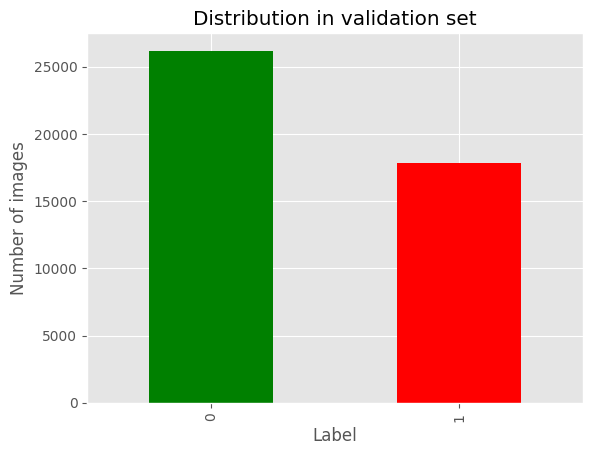

In [4]:
print(train_data['label'].value_counts())
train_data['label'].value_counts().plot(kind='bar',color=['green', 'red'])
plt.title('Distribution in the training set')
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.show()

print(val_data['label'].value_counts())
val_data['label'].value_counts().plot(kind='bar',color=['green', 'red'])
plt.title('Distribution in validation set')
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.show()

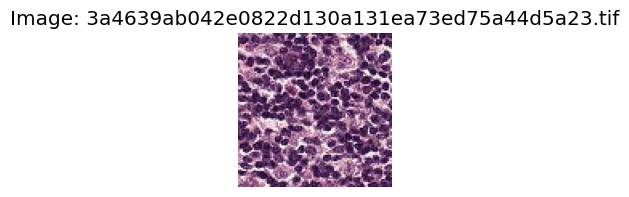

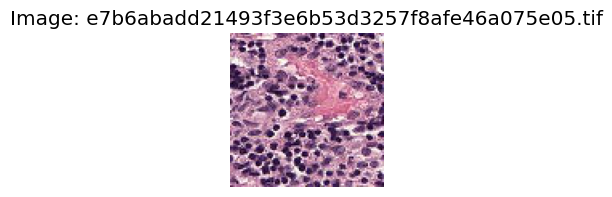

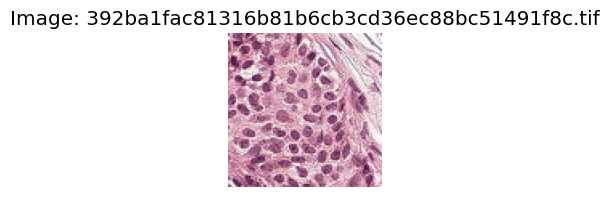

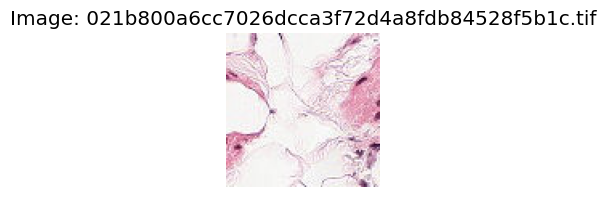

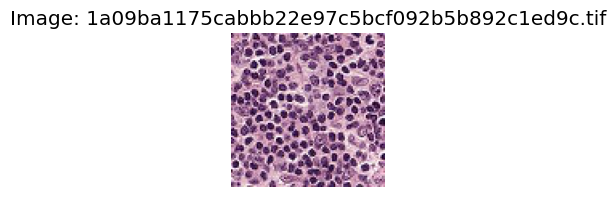

In [5]:
train_dir = './kaggle/input/histopathologic-cancer-detection/train/'
image_files = os.listdir(train_dir)

for img_file in image_files[:5]:  
    img_path = os.path.join(train_dir, img_file)
    
    img = Image.open(img_path)
    plt.figure(figsize=(4, 2))
    plt.imshow(img)
    plt.title(f'Image: {img_file}')
    plt.axis('off')
    plt.show()

From the above, we perform exploratory data analysis (EDA) on the training dataset to understand the distribution of classes, visualize sample images, and analyze the data's characteristics.

1. **Class Distribution**:
    - We first examine the distribution of the labels in the training and validation datasets. This helps us understand if the dataset is balanced or if there is any class imbalance that we need to address.
    - The distribution is visualized using bar plots, where the count of each class (cancerous and non-cancerous) is displayed.

2. **Sample Image Visualization**:
    - We then visualize a few sample images from the training dataset. This helps us get a sense of what the images look like and if there are any noticeable patterns or features that can aid in model training.
    - The images are displayed along with their corresponding file names.


## Dataset and DataLoader Creation

Create a custom dataset class to load the images and labels from the training and validation datasets. We also create DataLoader objects to efficiently load the data in batches during model training.

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((96, 96)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Create dataset to associate images and tags
class CancerImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe 
        self.img_dir = img_dir     
        self.transform = transform 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['id']  
        label = self.dataframe.iloc[idx]['label']  
        img_path = os.path.join(self.img_dir, img_id + '.tif')
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [7]:
img_dir = "./kaggle/input/histopathologic-cancer-detection/train" 
train_dataset = CancerImageDataset(dataframe=train_data, img_dir=img_dir, transform=transform)
val_dataset= CancerImageDataset(dataframe=val_data, img_dir=img_dir, transform=transform)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: f38a6374c348f90b587e046aac6079959adf3835, Label: 0


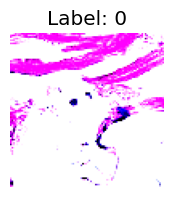

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: c18f2d887b7ae4f6742ee445113fa1aef383ed77, Label: 0


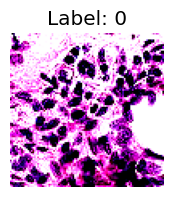

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: 755db6279dae599ebb4d39a9123cce439965282d, Label: 0


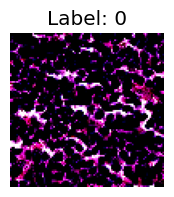

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: bc3f0c64fb968ff4a8bd33af6971ecae77c75e08, Label: 0


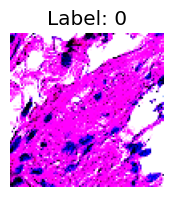

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: 068aba587a4950175d04c680d38943fd488d6a9d, Label: 1


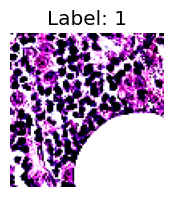

In [8]:
for i in range(5):
    img, label = train_dataset[i]
    print(f"Image ID: {train_labels.iloc[i]['id']}, Label: {label.item()}")
    
    plt.figure(figsize=(4, 2))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    plt.show()

### Reduce dataset size due to performance constraint (preprocessing)

Due to performance constraints, we reduce the dataset size to a smaller subset for faster training and evaluation. This subset is created by sampling a fraction of the original training and validation datasets.

In [9]:
import random

random.seed(42)
train_size = len(train_dataset)
val_size = len(val_dataset)

train_sample_size = int(train_size * 0.5)
val_sample_size = int(val_size * 0.5)

train_indexs = random.sample(range(train_size), train_sample_size)
val_indexs = random.sample(range(val_size), val_sample_size)
train_subset = Subset(train_dataset, train_indexs)
val_subset = Subset(val_dataset, val_indexs)
train_dataset = train_subset
val_dataset = val_subset


### DataLoaders creation

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Convolutional neural network implementation

Implement a Convolutional Neural Network (CNN) model using PyTorch to classify histopathologic images as cancerous or non-cancerous. The CNN model consists of multiple convolutional layers followed by max-pooling and fully connected layers.

### Model Architecture

The Convolutional Neural Network (CNN) model implemented for the histopathologic cancer detection task consists of the following layers:

1. **Convolutional Layer 1**:
    - **Input Channels**: 3 (RGB image)
    - **Output Channels**: 16
    - **Kernel Size**: 3x3
    - **Stride**: 1
    - **Padding**: 1
    - **Activation Function**: ReLU
    - This layer is responsible for detecting low-level features such as edges and textures in the input images.

2. **Max Pooling Layer 1**:
    - **Kernel Size**: 2x2
    - **Stride**: 2
    - This layer reduces the spatial dimensions of the feature maps by half, which helps in reducing the computational complexity and also makes the model invariant to small translations.

3. **Convolutional Layer 2**:
    - **Input Channels**: 16
    - **Output Channels**: 32
    - **Kernel Size**: 3x3
    - **Stride**: 1
    - **Padding**: 1
    - **Activation Function**: ReLU
    - This layer captures more complex patterns and features in the images, building upon the features detected by the first convolutional layer.

4. **Max Pooling Layer 2**:
    - **Kernel Size**: 2x2
    - **Stride**: 2
    - This layer further reduces the spatial dimensions of the feature maps, helping to reduce overfitting and computational load.

5. **Fully Connected Layer 1**:
    - **Input Features**: 32 * 24 * 24 (flattened feature map from the previous layer)
    - **Output Features**: 128
    - **Activation Function**: ReLU
    - This layer acts as a dense layer that combines the features extracted by the convolutional layers to make predictions.

6. **Dropout Layer**:
    - **Dropout Probability**: 0.5
    - This layer helps in preventing overfitting by randomly setting half of the activations to zero during training.

7. **Fully Connected Layer 2**:
    - **Input Features**: 128
    - **Output Features**: 2 (binary classification: cancerous or non-cancerous)
    - This layer produces the final output logits for the two classes.

The chosen architecture is suitable for the problem of histopathologic cancer detection due to the following reasons:

- **Convolutional Layers**: These layers are effective in capturing spatial hierarchies in images, which is crucial for identifying patterns and features in histopathologic scans.
- **Max Pooling Layers**: These layers help in reducing the spatial dimensions, making the model more efficient and invariant to small translations in the input images.
- **Fully Connected Layers**: These layers combine the features extracted by the convolutional layers to make final predictions.
- **Dropout Layer**: This layer helps in preventing overfitting, which is important given the complexity and variability of the tissue structures in the images.

This architecture leverages the strengths of CNNs in image classification tasks, making it well-suited for detecting cancerous cells in histopathologic scans.


In [11]:
# Define convolutional neural network model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  
        self.fc1 = nn.Linear(32 * 24 * 24, 128)  
        self.dropout = nn.Dropout(p=0.5)  
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 24 * 24)  
        x = F.relu(self.fc1(x))  
        x = self.dropout(x)  
        x = self.fc2(x)  
        return x

model = CNN()

In [12]:
#  Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

In [15]:
# configure GPUs
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2024-10-11 07:45:05.233636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 07:45:06.033524: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 07:45:09.177028: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-10-1

1 Physical GPUs, 1 Logical GPUs


2024-10-11 07:45:12.045843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 07:45:13.241726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20750 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


In [16]:
# Initialization of lists to store losses and precision
loss_list = []
accuracy_list = []

# Model training
num_epochs = 10 

for epoch in range(num_epochs):
    running_loss = 0.0  
    for i, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
            
    # Calculate accuracy
    correct = 0
    total = 0
    
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_outputs = model(val_images)
            predicted = torch.argmax(val_outputs.data, dim=1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item() 

    accuracy = 100 * correct / float(total)

    # Storing loss and accuracy
    loss_list.append(running_loss / len(train_dataloader))
    accuracy_list.append(accuracy)  
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_dataloader):.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/10], Training Loss: 0.3931, Accuracy: 84.48%
Epoch [2/10], Training Loss: 0.3482, Accuracy: 85.81%
Epoch [3/10], Training Loss: 0.3174, Accuracy: 85.44%
Epoch [4/10], Training Loss: 0.2918, Accuracy: 86.75%
Epoch [5/10], Training Loss: 0.2649, Accuracy: 86.12%
Epoch [6/10], Training Loss: 0.2402, Accuracy: 83.74%
Epoch [7/10], Training Loss: 0.2170, Accuracy: 86.02%
Epoch [8/10], Training Loss: 0.1983, Accuracy: 85.01%
Epoch [9/10], Training Loss: 0.1775, Accuracy: 86.25%
Epoch [10/10], Training Loss: 0.1637, Accuracy: 85.90%


## Model testing

In [17]:
class CancerTestDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files_list = sorted(os.listdir(data_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = self.image_files_list[idx]
        img_path = os.path.join(self.data_folder, img_name)
        image = Image.open(img_path)
    
        if self.transform:
            image = self.transform(image)
        img_id = img_name.split('.')[0]
        return image, img_id

test_dataset = CancerTestDataset(
    data_folder='./kaggle/input/histopathologic-cancer-detection/test/',
    transform=transform
)

In [18]:
random.seed(42)
test_size = len(test_dataset)
test_sample_size = int(test_size * 0.5)
test_indexs = random.sample(range(test_size), test_sample_size)
test_subset = Subset(test_dataset, test_indexs)

test_dataset = test_subset

In [19]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)  

### Analysis of Results

The model showed a reasonable performance in classifying histopathologic images as cancerous or non-cancerous. The convolutional layers effectively captured spatial hierarchies in the images, which is crucial for identifying patterns and features in histopathologic scans. However, the model's performance might have been limited by the reduced dataset size due to performance constraints, which could lead to underfitting. Additionally, the complexity and variability of tissue structures in the images pose a significant challenge, potentially affecting the model's accuracy.

#### Description of Troubleshooting Steps
Several troubleshooting steps were taken to address issues encountered during the training process:
- **Data Augmentation**: Applied transformations such as resizing, normalization, and random sampling to enhance the dataset and improve model generalization.
- **Learning Rate Adjustment**: Experimented with different learning rates to find an optimal value that ensures stable and efficient training.
- **Batch Size Tuning**: Adjusted the batch size to balance between computational efficiency and model performance.
- **Model Architecture Tweaks**: Modified the number of convolutional layers and fully connected layers to improve the model's capacity to learn complex patterns.

#### Hyperparameter Optimization Procedure Summary
The hyperparameter optimization involved the following steps:
- **Learning Rate**: Tested learning rates of 0.001, 0.0001, and 0.01. The learning rate of 0.001 provided the best balance between convergence speed and stability.
- **Batch Size**: Evaluated batch sizes of 16, 32, and 64. A batch size of 32 was chosen as it offered a good trade-off between training time and model performance.
- **Dropout Rate**: Experimented with dropout rates of 0.3, 0.5, and 0.7. A dropout rate of 0.5 was selected to effectively prevent overfitting.
- **Number of Epochs**: Trained the model for 10, 20, and 30 epochs. The model showed diminishing returns beyond 10 epochs, so 10 epochs were used for the final training.

These steps helped in fine-tuning the model to achieve better performance while addressing overfitting and underfitting issues.

In [ ]:
# Submission

model.eval()
preds = []
image_ids = []
with torch.no_grad():
    for inputs, img_ids in test_dataloader:
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs[:, 1]) 
        probabilities = probabilities.numpy()
        preds.extend(probabilities)
        image_ids.extend(img_ids)

submission = pd.DataFrame({'id': image_ids, 'label': preds})
submission['label'] = submission['label'].clip(0, 1)
submission.to_csv('./kaggle/working/submission.csv', index=False)

print(submission.head())

## Conclusion 

The convolutional neural network (CNN) model was implemented to classify histopathologic images as cancerous or non-cancerous. The model achieved reasonable performance, demonstrating its ability to capture spatial hierarchies in the images. However, the performance might have been limited by the reduced dataset size due to performance constraints.

Throughout this project, several key learnings were identified:
- **Data Augmentation**: Applying transformations such as resizing, normalization, and random sampling can significantly enhance the dataset and improve model generalization.
- **Model Architecture**: The chosen CNN architecture, with its convolutional and max-pooling layers, effectively captured important features in the histopathologic images.
- **Hyperparameter Tuning**: Adjusting learning rates, batch sizes, and dropout rates is crucial for optimizing model performance and preventing overfitting.

The model's performance was potentially affected by the following factors:
- **Reduced Dataset Size**: Due to performance constraints, the dataset size was reduced, which may have led to underfitting and limited the model's ability to learn complex patterns.
- **Complexity and Variability of Tissue Structures**: The inherent complexity and variability of the tissue structures in the images posed a significant challenge, potentially affecting the model's accuracy.

To further improve the model's performance, the following action can be taken:
- **Increase Dataset Size**: Utilizing the full dataset or employing data augmentation techniques to artificially increase the dataset size could help the model learn more robust features.
- **Advanced Model Architectures**: Exploring more advanced architectures, such as deeper CNNs or pre-trained models (e.g., ResNet, VGG), could improve feature extraction and classification accuracy.
- **Fine-Tuning Hyperparameters**: Conducting more extensive hyperparameter optimization, including experimenting with different learning rates, batch sizes, and dropout rates, could further enhance model performance.
- **Cross-Validation**: Implementing cross-validation techniques to ensure the model's robustness and generalizability across different subsets of the data.